In [1]:
import copy
import csv
import os
import warnings
from argparse import ArgumentParser
import numpy as np

import torch
from tqdm import tqdm
import yaml
from torch.utils import data
# 개별 json 라벨 파일을 이용해 학습 데이터 리스트 생성
import glob
import json
import os
from nets import nn
from utils import util
from utils.dataset import Dataset
from torch.utils import data
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:",device)

device: cuda:0


In [2]:
def crop_image_and_label(crop_h,crop_w,label,input_size):
    temp_labels = []
    for k in range(len(label)):
        x = label[k][2]
        y = label[k][1]
        w = label[k][4]
        h = label[k][3]
        if x >= crop_h and y >= crop_w and x <= crop_h + input_size and y <= crop_w + input_size:
            label[k][1] = (y+h/2 - crop_w)/ input_size
            label[k][2] = (x+w/2 - crop_h)/ input_size
            label[k][3] = (h) / input_size
            label[k][4] = (w) / input_size
            temp_labels.append(label[k])
    return temp_labels
    
def find_key_by_value(dictionary, target_value):
    """value로 key 찾기"""
    for key, value in dictionary.items():
        if value == target_value:
            return key
    return None 
 
# 파라미터 및 데이터 경로 설정
with open('utils/args.yaml', errors='ignore') as f:
    params = yaml.safe_load(f) 
input_size = 512
label_dir = '../../data/validation_patch_her2/validations_1/'
origin_size=1024
label_files = sorted(glob.glob(os.path.join(label_dir, 'annotation*.json')))
filenames = []
origin_labels = []
# 라벨이 존재하는 이미지
for label_file in label_files:
    with open(label_file) as f:
        data1 = json.load(f)
    img_name=data1["filename"].replace("BRCA-","BRCA-SS-")# 이거 한정
    img_path = label_dir.replace('validations_1', 'images')+"CODIPAI-"+img_name
    if os.path.exists(img_path):
        filenames.append(img_path)
        temp_labels = []
        objects = data1["objects"]
        for i in range(len(objects)):
            temp_labels.append([find_key_by_value(params['names'], objects[i]['label']),int(objects[i]["coordinate"][0][0]),
                         int(objects[i]["coordinate"][0][1]),32,32])
        origin_labels.append(temp_labels)
# 라벨을 할수 없는 이미지
# with open(label_dir+"cancel_list.json") as f:
#     data1 = json.load(f)
# for i in range(len(data1)):
#     data1[i]['IMAGE']=data1[i]['IMAGE'].split('/')[-1]
#     img_name=data1[i]['IMAGE'].replace("BRCA-","BRCA-SS-")# 이거 한정
#     img_path=label_dir.replace('validations_1', 'images')+"CODIPAI-"+img_name
#     origin_labels.append([])
#     filenames.append(img_path)
# 이미지 메모리 로드

images = []
labels=[]

for i in tqdm(range(len(filenames))):
    image = cv2.resize(cv2.imread(filenames[i]), (input_size, input_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR -> RGB 변환
    temp_labels = []
    for j in range((len(origin_labels[i]))):
        temp_labels.append([origin_labels[i][j][0],origin_labels[i][j][1]/origin_size,
                         origin_labels[i][j][2]/origin_size,origin_labels[i][j][3]/origin_size,
                         origin_labels[i][j][4]/origin_size])
    labels.append(temp_labels)

    images.append(image)


100%|██████████| 230/230 [00:07<00:00, 32.45it/s]


In [3]:
def collate_fn1(batch):
    samples, cls, box, indices = zip(*batch)

    cls = torch.cat(cls, dim=0)
    box = torch.cat(box, dim=0)

    new_indices = list(indices)
    for i in range(len(indices)):
        new_indices[i] += i
    indices = torch.cat(new_indices, dim=0)

    targets = {'cls': cls,
                'box': box,
                'idx': indices}
    return torch.stack(samples, dim=0), targets

class custom_dataset(data.Dataset):
    def __init__(self, images, params, augment, labels, image_infos=None):
        self.params = params
        self.mosaic = augment
        self.augment = augment
        self.images = images
        self.labels = labels
        self.scale_list = [256, 288, 320, 352, 384, 416, 448, 480, 512]
        self.current_scale = 512  # 배치 단위로 관리될 현재 스케일
        self.n = len(self.images)
        self.indices = list(range(self.n))*10
    def __len__(self):
        return len(self.indices)
    def set_scale(self, scale):
        """배치 단위로 스케일 설정"""
        self.current_scale = scale
    
    def random_multi_scale(self, image, label):
        # 현재 설정된 스케일 사용 (배치 내 모든 이미지가 동일한 크기)
        size = self.current_scale
        image = cv2.resize(image, (size, size))
        temp_labels = []
        for i in range(len(label)):
            x_center = label[i][2]
            y_center = label[i][1]
            w = label[i][4]
            h = label[i][3]
            temp_labels.append([label[i][0], y_center, x_center, h, w])
        return image, temp_labels
    
    def __getitem__(self, index):
        
        index = self.indices[index]
        image = self.images[index]
        label=self.labels[index]
        image,label=self.random_multi_scale(image,label)
        cls=[]
        box=[]
        for i in range(len(label)):
            cls.append(label[i][0])
            box.append(label[i][1:5])
        cls=np.array(cls) # class index 0부터 시작하도록 변경
        box=np.array(box)
        nl = len(box)
        if self.augment:
            nl = len(box)  # update after albumentations

            # Flip up-down
            if random.random() < self.params['flip_ud']:
                image = np.flipud(image).copy()
                if nl:
                    box[:, 1] = 1 - box[:, 1]
            # Flip left-right
            if random.random() < self.params['flip_lr']:
                image = np.fliplr(image).copy()
                if nl:
                    box[:, 0] = 1 - box[:, 0]

        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image),torch.from_numpy(cls), torch.from_numpy(box), torch.zeros(nl)
    

split=[0.9, 0.1]
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, 
    test_size=0.1,        # 테스트 비율
    random_state=42,       
    shuffle=True          # 셔플 여부
)

# 3-way split도 가능
train_dataset=custom_dataset(X_train, params, augment=True, labels=y_train)
val_dataset = custom_dataset(X_test, params, augment=False, labels=y_test)

🖼️ Train Dataset 첫 번째 샘플 시각화


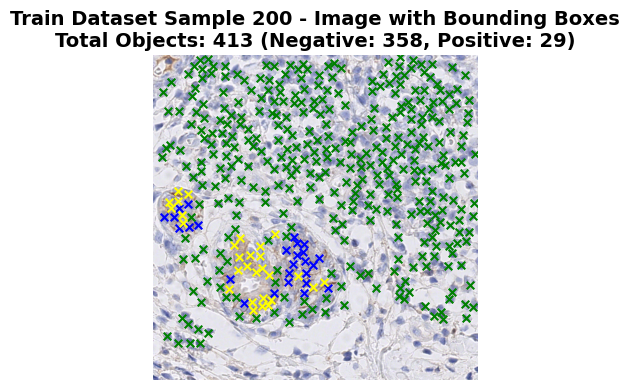

📊 Sample 200 상세 정보:
  이미지 크기: 512 x 512
  총 객체 수: 413

🔍 각 객체별 정보:
  객체 1: class_0
    중심점: (0.272, 0.384)
    크기: 0.031 x 0.031
  객체 2: class_0
    중심점: (0.559, 0.419)
    크기: 0.031 x 0.031
  객체 3: class_0
    중심점: (0.207, 0.345)
    크기: 0.031 x 0.031
  객체 4: class_0
    중심점: (0.167, 0.694)
    크기: 0.031 x 0.031
  객체 5: class_0
    중심점: (0.227, 0.308)
    크기: 0.031 x 0.031
  객체 6: class_2
    중심점: (0.445, 0.615)
    크기: 0.031 x 0.031
  객체 7: class_0
    중심점: (0.491, 0.779)
    크기: 0.031 x 0.031
  객체 8: class_0
    중심점: (0.444, 0.446)
    크기: 0.031 x 0.031
  객체 9: class_0
    중심점: (0.372, 0.790)
    크기: 0.031 x 0.031
  객체 10: class_0
    중심점: (0.123, 0.374)
    크기: 0.031 x 0.031
  객체 11: class_0
    중심점: (0.204, 0.661)
    크기: 0.031 x 0.031
  객체 12: class_0
    중심점: (0.484, 0.403)
    크기: 0.031 x 0.031
  객체 13: class_0
    중심점: (0.854, 0.066)
    크기: 0.031 x 0.031
  객체 14: class_0
    중심점: (0.532, 0.212)
    크기: 0.031 x 0.031
  객체 15: class_0
    중심점: (0.256, 0.491)
    크기: 0.031 x 0.0

In [4]:
def visualize_sample_with_overlay(dataset, index=0):
    """
    데이터셋의 특정 샘플에 대해 바운딩 박스를 오버레이한 이미지를 시각화합니다.
    
    Args:
        dataset: 커스텀 데이터셋
        index: 시각화할 샘플의 인덱스
    """
    # 샘플 가져오기
    image_tensor, cls_tensor, box_tensor, _ = dataset[index]
    
    # 텐서를 numpy 배열로 변환
    # 이미지: (C, H, W) -> (H, W, C)
    image = image_tensor.numpy().transpose(1, 2, 0)
    cls = cls_tensor.numpy()
    boxes = box_tensor.numpy()

    # 이미지 크기
    height, width = image.shape[:2]
    
    # 클래스 이름 및 색상 설정
    class_names = {0: 'class_0', 1: 'class_1', 2: 'class_2',3: 'class_3'}
    colors = ['green','yellow','blue','red']  # negative: red, positive: blue, non-tumor: green

    # 시각화
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow(image.astype(np.uint8))
    
    # 각 바운딩 박스 그리기
    for i in range(len(boxes)):
        # YOLO 형식 (center_x, center_y, width, height)을 픽셀 좌표로 변환
        center_x, center_y, box_width, box_height = boxes[i]
        
        # 상대 좌표를 픽셀 좌표로 변환
        center_x_pixel = center_x * width
        center_y_pixel = center_y * height
        box_width_pixel = box_width * width
        box_height_pixel = box_height * height
        
        # 좌상단 좌표 계산
        x1 = center_x_pixel - box_width_pixel / 2
        y1 = center_y_pixel - box_height_pixel / 2
        
        # 클래스 정보
        class_id = int(cls[i])
        class_name = class_names.get(class_id, f'Class {class_id}')
        color = colors[class_id] if class_id < len(colors) else 'green'
        
        # 바운딩 박스 그리기
        # rect = patches.Rectangle(
        #     (x1, y1), box_width_pixel, box_height_pixel,
        #     linewidth=2, edgecolor=color, facecolor='none'
        # )
        # ax.add_patch(rect)
        ax.scatter(center_x_pixel, center_y_pixel, c=color, s=30, marker='x')
        
    
    ax.set_title(f'Train Dataset Sample {index} - Image with Bounding Boxes\n'
                f'Total Objects: {len(boxes)} '
                f'(Negative: {sum(cls == 0)}, Positive: {sum(cls == 1)})', 
                fontsize=14, fontweight='bold')
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 상세 정보 출력
    print(f"📊 Sample {index} 상세 정보:")
    print(f"  이미지 크기: {width} x {height}")
    print(f"  총 객체 수: {len(boxes)}")
    print("\n🔍 각 객체별 정보:")
    for i in range(len(boxes)):
        center_x, center_y, box_w, box_h = boxes[i]
        class_id = int(cls[i])
        class_name = class_names.get(class_id, f'Class {class_id}')
        print(f"  객체 {i+1}: {class_name}")
        print(f"    중심점: ({center_x:.3f}, {center_y:.3f})")
        print(f"    크기: {box_w:.3f} x {box_h:.3f}")

# train_dataset[0] 시각화 실행
print("🖼️ Train Dataset 첫 번째 샘플 시각화")
print("=" * 50)
visualize_sample_with_overlay(train_dataset, index=200)

In [5]:


# 모델 및 파라미터 준비
model = nn.yolo_v11_m(len(params['names'])).to(device)
optimizer = torch.optim.AdamW(util.set_params(model, params['weight_decay']),
                             lr=2e-4, 
                             betas=(0.9, 0.999),
                             weight_decay=params['weight_decay'])
criterion = util.ComputeLoss(model, params)

# 데이터셋 및 데이터로드 (안전한 함수 사용)
batch_size = 8
# 안전하게 데이터로더 생성하는 함수
def create_safe_loader(dataset, batch_size, is_train=True):
    """
    배치 크기에 맞게 데이터셋을 조정하여 안전하게 데이터로더를 생성하는 함수
    """
    dataset_size = len(dataset)
    
    # 배치 크기가 데이터셋 크기보다 큰 경우 배치 크기 조정
    if dataset_size < batch_size:
        print(f"경고: 데이터셋 크기({dataset_size})가 배치 크기({batch_size})보다 작습니다. 배치 크기를 {dataset_size}로 조정합니다.")
        actual_batch_size = max(1, dataset_size)
    else:
        actual_batch_size = batch_size
    
    # 데이터셋이 배치 크기로 나누어 떨어지는지 확인
    if dataset_size % actual_batch_size != 0:
        print(f"참고: 데이터셋 크기({dataset_size})가 배치 크기({actual_batch_size})로 나누어 떨어지지 않습니다.")
        print(f"마지막 배치는 {dataset_size % actual_batch_size}개의 샘플을 포함합니다.")
    
    # 데이터로더 생성
    loader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=actual_batch_size, 
        shuffle=is_train,
        num_workers=4,
        collate_fn=collate_fn1,
        drop_last=(not is_train)  # 훈련 시에는 마지막 배치 유지, 검증 시에는 마지막 배치 제외
    )
    
    return loader, actual_batch_size
# 안전하게 데이터로더 생성
loader, train_batch_size = create_safe_loader(train_dataset, batch_size, is_train=True)
val_loader, val_batch_size = create_safe_loader(val_dataset, batch_size, is_train=False)

print(f"최종 훈련 배치 크기: {train_batch_size}")
print(f"최종 검증 배치 크기: {val_batch_size}")



참고: 데이터셋 크기(2070)가 배치 크기(8)로 나누어 떨어지지 않습니다.
마지막 배치는 6개의 샘플을 포함합니다.
참고: 데이터셋 크기(230)가 배치 크기(8)로 나누어 떨어지지 않습니다.
마지막 배치는 6개의 샘플을 포함합니다.
최종 훈련 배치 크기: 8
최종 검증 배치 크기: 8


In [ ]:
from utils.valid import compute_point_label_metrics  # Point-label 최적화 메트릭
from utils.valid import visualize_ground_truth_and_prediction_separately
from utils.valid import plot_training_progress


# main.py의 train 함수를 참조한 개선된 학습 루프
train_losses = []

# Point-label 메트릭용 리스트
val_det_recalls = []  # Detection Recall
val_cls_accs = []     # Classification Accuracy
val_macro_f1s = []    # Macro F1-score
val_macro_precisions = []  # Macro Precision
val_macro_recalls = []  # Macro Recall

epochs = 10000
scale_list = [256, 288, 320, 352, 384, 416, 448, 480, 512]
# 체크포인트 저장을 위한 디렉토리 생성
save_dir = '../../model/her2_validation_1/'
os.makedirs(save_dir, exist_ok=True)
#체크포인트 불러오기 
# checkpoint_path = os.path.join(save_dir, 'last_model.pt')
# if os.path.exists(checkpoint_path):
#     checkpoint = torch.load(checkpoint_path, map_location=device,weights_only=False)
#     model.load_state_dict(checkpoint['model_state_dict'])
    
# main.py 스타일의 설정들
best_macro_f1 = 0  # 베스트 모델 기준: macro_f1
accumulate = max(round(64 / batch_size), 1)  # gradient accumulation steps
amp_scale = torch.amp.GradScaler()  # mixed precision scaler

print(f"Gradient accumulation steps: {accumulate}")

for epoch in range(epochs):
    # 훈련
    model.train()
    
    # main.py 스타일의 평균 손실 추적
    avg_box_loss = util.AverageMeter()
    avg_cls_loss = util.AverageMeter()
    avg_dfl_loss = util.AverageMeter()
    
    train_pbar = tqdm(enumerate(loader), total=len(loader), desc=f'Epoch {epoch+1}/{epochs} Training')
    
    optimizer.zero_grad()
    current_scale = random.choice(scale_list)
    train_dataset.set_scale(current_scale)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        collate_fn=collate_fn1,
        drop_last=True
    )
    for i, (torch_images, targets) in train_pbar:
        step = i + len(loader) * epoch
        torch_images = torch_images.to(device).float() / 255
        
        # Forward pass with mixed precision
        with torch.amp.autocast('cuda'):
            outputs = model(torch_images)
            loss_box, loss_cls, loss_dfl = criterion(outputs, targets)
        
        # 평균 손실 업데이트
        avg_box_loss.update(loss_box.item(), torch_images.size(0))
        avg_cls_loss.update(loss_cls.item(), torch_images.size(0))
        avg_dfl_loss.update(loss_dfl.item(), torch_images.size(0))
        
        # Loss scaling for gradient accumulation
        loss_box *= batch_size  # loss scaled by batch_size
        loss_cls *= batch_size  # loss scaled by batch_size  
        loss_dfl *= batch_size  # loss scaled by batch_size
        
        total_loss = loss_box + loss_cls + loss_dfl
        
        # Backward pass with gradient scaling
        amp_scale.scale(total_loss).backward()
        
        # Gradient accumulation 및 optimization
        if step % accumulate == 0:
            # Gradient clipping 및 optimization
            amp_scale.step(optimizer)
            amp_scale.update()
            optimizer.zero_grad()
        
        # GPU 메모리 동기화
        torch.cuda.synchronize()
        
        # 진행률 표시 업데이트 (main.py 스타일)
        memory = f'{torch.cuda.memory_reserved() / 1E9:.4g}G'
        s = f'Memory: {memory} | Box: {avg_box_loss.avg:.3f} | Cls: {avg_cls_loss.avg:.3f} | DFL: {avg_dfl_loss.avg:.3f}'
        train_pbar.set_description(f'Epoch {epoch+1}/{epochs} | {s}')
    
    # 에폭 평균 손실 계산
    avg_train_loss = avg_box_loss.avg + avg_cls_loss.avg + avg_dfl_loss.avg
    train_losses.append(avg_train_loss)
    val_dataset.set_scale(512)
    
    # Point-label 최적화 메트릭 계산 (주요 평가 지표)
    point_metrics = compute_point_label_metrics(
        model, val_loader, device, params, distance_threshold=16
    )
    
    detection_recall = point_metrics.get('detection_recall', 0)
    cls_accuracy = point_metrics.get('classification_accuracy', 0)
    macro_precision = point_metrics.get('macro_precision', 0)
    macro_recall = point_metrics.get('macro_recall', 0)
    macro_f1 = point_metrics.get('macro_f1', 0)
    overall_recall = point_metrics.get('overall_recall', 0)
    class_stats = point_metrics.get('class_stats', {})
    
    val_det_recalls.append(detection_recall)
    val_cls_accs.append(cls_accuracy)
    val_macro_f1s.append(macro_f1)
    val_macro_precisions.append(macro_precision)
    val_macro_recalls.append(macro_recall)
    
    # 결과 출력
    print(f"\nEpoch {epoch+1}/{epochs} Results:")
    print(f"  Train Loss - Box: {avg_box_loss.avg:.4f}, Cls: {avg_cls_loss.avg:.4f}, DFL: {avg_dfl_loss.avg:.4f}, Total: {avg_train_loss:.4f}")
    print(f"\n🎯 Point-Label Metrics:")
    print(f"  Detection Recall: {detection_recall:.4f} (GT 중 찾은 비율)")
    print(f"  Classification Accuracy: {cls_accuracy:.4f} (찾은 세포의 분류 정확도)")
    print(f"  Macro Precision: {macro_precision:.4f}")
    print(f"  Macro Recall: {macro_recall:.4f}")
    print(f"  Macro F1-score: {macro_f1:.4f} ⭐")
    print(f"  Overall Recall: {overall_recall:.4f}")
    print(f"\n📋 클래스별 상세:")
    for cls_name, stats in class_stats.items():
        print(f"  {cls_name}: P={stats['precision']:.3f}, R={stats['recall']:.3f}, F1={stats['f1']:.3f} "
              f"(TP={stats['tp']}, FP={stats['fp']}, FN={stats['fn']}, GT={stats['gt_count']})")
    print("-" * 80)
    
    
    # 베스트 모델 저장 (Macro F1 기준)
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        save_checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'amp_scale_state_dict': amp_scale.state_dict(),
            'train_loss': avg_train_loss,
            'box_loss': avg_box_loss.avg,
            'cls_loss': avg_cls_loss.avg,
            'dfl_loss': avg_dfl_loss.avg,
            # Point-label 메트릭
            'detection_recall': detection_recall,
            'classification_accuracy': cls_accuracy,
            'macro_precision': macro_precision,
            'macro_recall': macro_recall,
            'macro_f1': macro_f1,
            'overall_recall': overall_recall,
            'class_stats': class_stats,
            'params': params
        }
        torch.save(save_checkpoint, os.path.join(save_dir, 'best_model.pt'))
        print(f"🎉 새로운 베스트 모델 저장! Macro F1: {macro_f1:.4f}")
    
    # 최신 모델도 저장 (main.py 스타일)
    last_checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'amp_scale_state_dict': amp_scale.state_dict(),
        'train_loss': avg_train_loss,
        'box_loss': avg_box_loss.avg,
        'cls_loss': avg_cls_loss.avg,
        'dfl_loss': avg_dfl_loss.avg,
        # Point-label 메트릭
        'detection_recall': detection_recall,
        'classification_accuracy': cls_accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'overall_recall': overall_recall,
        'class_stats': class_stats,
        'params': params
    }
    torch.save(last_checkpoint, os.path.join(save_dir, 'last_model.pt'))
    
    # 100 에폭마다 학습 진행 그래프 생성 및 저장 (Point-label 메트릭만)
    if (epoch + 1) % 100 == 0:
        try:
            print(f"\n📊 Epoch {epoch+1} - 학습 진행 상황 그래프 생성 중...")
            plot_training_progress(
                train_losses, val_det_recalls, val_cls_accs, val_macro_precisions, 
                val_macro_recalls, val_macro_f1s, epoch+1, save_dir
            )
        except Exception as e:
            print(f"그래프 생성 중 오류: {e}")
    
    # 개선된 검증 이미지 시각화 (매 10 에폭마다) - 실제 라벨과 예측 라벨을 별도 figure로 표시
    if (epoch+1) % 10 == 0:
        try:
            # 여러 샘플에 대해 시각화
            num_samples = 1 # 샘플 수를 1개
            for sample_idx in range(num_samples):
                print(f"\n📊 Epoch {epoch+1} - 검증 샘플 {sample_idx+1}/{num_samples}:")
                print("=" * 60)
                
                # 실제 라벨과 예측 라벨을 별도 figure로 표시
                sample_idx = random.randint(0, len(val_dataset)-1)
                visualize_ground_truth_and_prediction_separately(
                    model, val_dataset, idx=sample_idx, 
                    epoch=epoch+1, save_dir=save_dir
                )
                
        except Exception as e:
            print(f"시각화 중 오류: {e}")

print("🎯 학습 완료!")
print(f"최종 베스트 Macro F1: {best_macro_f1:.4f}")
print(f"모델 저장 위치: {save_dir}")
print(f"베스트 모델: {os.path.join(save_dir, 'best_model.pt')}")
print(f"최신 모델: {os.path.join(save_dir, 'last_model.pt')}")

# 최종 성능 요약
if val_macro_f1s:
    final_macro_f1 = val_macro_f1s[-1]
    final_det_recall = val_det_recalls[-1]
    final_cls_acc = val_cls_accs[-1]
    final_macro_precision = val_macro_precisions[-1]
    final_macro_recall = val_macro_recalls[-1]
    
    print(f"\n📊 최종 성능 요약 (Point-Label Metrics):")
    print(f"  Macro F1-score: {final_macro_f1:.4f} ⭐")
    print(f"  Macro Precision: {final_macro_precision:.4f}")
    print(f"  Macro Recall: {final_macro_recall:.4f}")
    print(f"  Detection Recall: {final_det_recall:.4f}")
    print(f"  Classification Accuracy: {final_cls_acc:.4f}")


Gradient accumulation steps: 8


Epoch 1/10000 Training:   0%|          | 0/259 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3611.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.12/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3611.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Epoch 1/10000 | Memory: 4.127G | Box: 0.378 | Cls: 353.277 | DFL: 0.191: 100%|██████████| 259/259 [00:18<00:00, 14.36it/s]
Epoch 1/10000 | Memory: 4.127G | Box: 0.378 | Cls: 353.277 | DFL: 0.191: 100%|██████████| 259/259 [00:18<00:00, 14.36it/s]


경고: 매칭된 객체가 없어 Kappa를 계산할 수 없습니다.

Epoch 1/10000 Results:
  Train Loss - Box: 0.3781, Cls: 353.2771, DFL: 0.1911, Total: 353.8463
  Cohen's Kappa: 0.0000 (Slight)

🎯 Point-Label Metrics (주요 지표):
  Detection Recall: 0.0085 (GT 중 찾은 비율)
  Classification Accuracy: 0.7231 (찾은 세포의 분류 정확도)
  Macro Precision: 0.1008
  Macro Recall: 0.0054
  Macro F1-score: 0.0103 ⭐
  Overall Recall: 0.0061

Epoch 1/10000 Results:
  Train Loss - Box: 0.3781, Cls: 353.2771, DFL: 0.1911, Total: 353.8463
  Cohen's Kappa: 0.0000 (Slight)

🎯 Point-Label Metrics (주요 지표):
  Detection Recall: 0.0085 (GT 중 찾은 비율)
  Classification Accuracy: 0.7231 (찾은 세포의 분류 정확도)
  Macro Precision: 0.1008
  Macro Recall: 0.0054
  Macro F1-score: 0.0103 ⭐
  Overall Recall: 0.0061
🎉 새로운 베스트 모델 저장! Macro F1: 0.0103
🎉 새로운 베스트 모델 저장! Macro F1: 0.0103


Epoch 2/10000 | Memory: 4.19G | Box: 1.409 | Cls: 52.437 | DFL: 0.455: 100%|██████████| 259/259 [00:15<00:00, 17.16it/s] 
Epoch 2/10000 | Memory: 4.19G | Box: 1.409 | Cls: 52.437 | DFL: 0.455: 100%|██████████| 259/259 [00:15<00:00, 17.16it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:758: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/usr/local/lib/python3.12/d


Epoch 2/10000 Results:
  Train Loss - Box: 1.4094, Cls: 52.4371, DFL: 0.4555, Total: 54.3020
  Cohen's Kappa: nan (Almost Perfect)

🎯 Point-Label Metrics (주요 지표):
  Detection Recall: 0.0045 (GT 중 찾은 비율)
  Classification Accuracy: 0.8438 (찾은 세포의 분류 정확도)
  Macro Precision: 0.0372
  Macro Recall: 0.0034
  Macro F1-score: 0.0062 ⭐
  Overall Recall: 0.0038


Epoch 3/10000 | Memory: 4.19G | Box: 1.127 | Cls: 26.398 | DFL: 0.400: 100%|██████████| 259/259 [00:15<00:00, 16.88it/s]




Epoch 3/10000 Results:
  Train Loss - Box: 1.1274, Cls: 26.3981, DFL: 0.4000, Total: 27.9254
  Cohen's Kappa: 0.0747 (Slight)

🎯 Point-Label Metrics (주요 지표):
  Detection Recall: 0.0253 (GT 중 찾은 비율)
  Classification Accuracy: 0.4557 (찾은 세포의 분류 정확도)
  Macro Precision: 0.0614
  Macro Recall: 0.0101
  Macro F1-score: 0.0172 ⭐
  Overall Recall: 0.0115
🎉 새로운 베스트 모델 저장! Macro F1: 0.0172
🎉 새로운 베스트 모델 저장! Macro F1: 0.0172


Epoch 4/10000 | Memory: 4.19G | Box: 1.002 | Cls: 24.298 | DFL: 0.501: 100%|██████████| 259/259 [00:15<00:00, 16.51it/s]




Epoch 4/10000 Results:
  Train Loss - Box: 1.0017, Cls: 24.2975, DFL: 0.5013, Total: 25.8005
  Cohen's Kappa: 0.0000 (Slight)

🎯 Point-Label Metrics (주요 지표):
  Detection Recall: 0.1042 (GT 중 찾은 비율)
  Classification Accuracy: 0.7835 (찾은 세포의 분류 정확도)
  Macro Precision: 0.1663
  Macro Recall: 0.0334
  Macro F1-score: 0.0556 ⭐
  Overall Recall: 0.0816
🎉 새로운 베스트 모델 저장! Macro F1: 0.0556
🎉 새로운 베스트 모델 저장! Macro F1: 0.0556


Epoch 5/10000 | Memory: 4.19G | Box: 0.961 | Cls: 19.064 | DFL: 0.450: 100%|██████████| 259/259 [00:15<00:00, 16.45it/s]
Epoch 5/10000 | Memory: 4.19G | Box: 0.961 | Cls: 19.064 | DFL: 0.450: 100%|██████████| 259/259 [00:15<00:00, 16.45it/s]



Epoch 5/10000 Results:
  Train Loss - Box: 0.9614, Cls: 19.0637, DFL: 0.4502, Total: 20.4753
  Cohen's Kappa: 0.7022 (Substantial)

🎯 Point-Label Metrics (주요 지표):
  Detection Recall: 0.3618 (GT 중 찾은 비율)
  Classification Accuracy: 0.8782 (찾은 세포의 분류 정확도)
  Macro Precision: 0.1694
  Macro Recall: 0.1876
  Macro F1-score: 0.1604 ⭐
  Overall Recall: 0.3177
🎉 새로운 베스트 모델 저장! Macro F1: 0.1604
🎉 새로운 베스트 모델 저장! Macro F1: 0.1604


Epoch 6/10000 | Memory: 4.19G | Box: 1.024 | Cls: 16.911 | DFL: 0.402: 100%|██████████| 259/259 [00:15<00:00, 16.55it/s]
Epoch 6/10000 | Memory: 4.19G | Box: 1.024 | Cls: 16.911 | DFL: 0.402: 100%|██████████| 259/259 [00:15<00:00, 16.55it/s]



Epoch 6/10000 Results:
  Train Loss - Box: 1.0245, Cls: 16.9109, DFL: 0.4024, Total: 18.3378
  Cohen's Kappa: 0.6921 (Substantial)

🎯 Point-Label Metrics (주요 지표):
  Detection Recall: 0.4188 (GT 중 찾은 비율)
  Classification Accuracy: 0.8697 (찾은 세포의 분류 정확도)
  Macro Precision: 0.1638
  Macro Recall: 0.1905
  Macro F1-score: 0.1656 ⭐
  Overall Recall: 0.3643
🎉 새로운 베스트 모델 저장! Macro F1: 0.1656
🎉 새로운 베스트 모델 저장! Macro F1: 0.1656


Epoch 7/10000 | Memory: 4.19G | Box: 0.903 | Cls: 15.600 | DFL: 0.383: 100%|██████████| 259/259 [00:15<00:00, 17.03it/s]
Epoch 7/10000 | Memory: 4.19G | Box: 0.903 | Cls: 15.600 | DFL: 0.383: 100%|██████████| 259/259 [00:15<00:00, 17.03it/s]



Epoch 7/10000 Results:
  Train Loss - Box: 0.9034, Cls: 15.6002, DFL: 0.3831, Total: 16.8867
  Cohen's Kappa: 0.7349 (Substantial)

🎯 Point-Label Metrics (주요 지표):
  Detection Recall: 0.5375 (GT 중 찾은 비율)
  Classification Accuracy: 0.8949 (찾은 세포의 분류 정확도)
  Macro Precision: 0.1704
  Macro Recall: 0.2483
  Macro F1-score: 0.1939 ⭐
  Overall Recall: 0.4810
🎉 새로운 베스트 모델 저장! Macro F1: 0.1939
🎉 새로운 베스트 모델 저장! Macro F1: 0.1939


Epoch 8/10000 | Memory: 4.19G | Box: 0.757 | Cls: 15.872 | DFL: 0.429: 100%|██████████| 259/259 [00:15<00:00, 16.55it/s]
Epoch 8/10000 | Memory: 4.19G | Box: 0.757 | Cls: 15.872 | DFL: 0.429: 100%|██████████| 259/259 [00:15<00:00, 16.55it/s]



Epoch 8/10000 Results:
  Train Loss - Box: 0.7570, Cls: 15.8722, DFL: 0.4287, Total: 17.0579
  Cohen's Kappa: 0.7713 (Substantial)

🎯 Point-Label Metrics (주요 지표):
  Detection Recall: 0.5417 (GT 중 찾은 비율)
  Classification Accuracy: 0.9121 (찾은 세포의 분류 정확도)
  Macro Precision: 0.2299
  Macro Recall: 0.2683
  Macro F1-score: 0.2176 ⭐
  Overall Recall: 0.4940
🎉 새로운 베스트 모델 저장! Macro F1: 0.2176
🎉 새로운 베스트 모델 저장! Macro F1: 0.2176


Epoch 9/10000 | Memory: 4.19G | Box: 0.772 | Cls: 14.650 | DFL: 0.372: 100%|██████████| 259/259 [00:15<00:00, 16.39it/s]




Epoch 9/10000 Results:
  Train Loss - Box: 0.7718, Cls: 14.6499, DFL: 0.3723, Total: 15.7941
  Cohen's Kappa: 0.7173 (Substantial)

🎯 Point-Label Metrics (주요 지표):
  Detection Recall: 0.5937 (GT 중 찾은 비율)
  Classification Accuracy: 0.9251 (찾은 세포의 분류 정확도)
  Macro Precision: 0.2457
  Macro Recall: 0.2955
  Macro F1-score: 0.2303 ⭐
  Overall Recall: 0.5492
🎉 새로운 베스트 모델 저장! Macro F1: 0.2303
🎉 새로운 베스트 모델 저장! Macro F1: 0.2303


Epoch 10/10000 | Memory: 4.192G | Box: 1.240 | Cls: 16.522 | DFL: 0.388: 100%|██████████| 259/259 [00:14<00:00, 17.87it/s]




Epoch 10/10000 Results:
  Train Loss - Box: 1.2404, Cls: 16.5216, DFL: 0.3879, Total: 18.1499
  Cohen's Kappa: 0.0000 (Slight)

🎯 Point-Label Metrics (주요 지표):
  Detection Recall: 0.5737 (GT 중 찾은 비율)
  Classification Accuracy: 0.9062 (찾은 세포의 분류 정확도)
  Macro Precision: 0.1571
  Macro Recall: 0.2761
  Macro F1-score: 0.1963 ⭐
  Overall Recall: 0.5198

📊 Epoch 10 - 검증 샘플 1/1:

📊 Epoch 10 - 검증 샘플 1/1:
✅ 비교 이미지 저장: ../../model/her2_validation_1/validation_comparison_epoch_10.png
✅ 비교 이미지 저장: ../../model/her2_validation_1/validation_comparison_epoch_10.png


Epoch 11/10000 | Memory: 4.192G | Box: 0.990 | Cls: 15.613 | DFL: 0.392:  17%|█▋        | 44/259 [00:02<00:12, 16.85it/s]

In [ ]:
# Cohen's Kappa 관련 함수들을 valid.py에서 import
from utils.valid import compute_validation_metrics_with_kappa, get_kappa_interpretation, quick_kappa_test

# 현재 모델의 빠른 Cohen's Kappa 테스트
print("🔍 현재 모델의 Cohen's Kappa 빠른 측정...")
current_kappa = quick_kappa_test(model, val_loader, device)